In [299]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np 
from sklearn.cluster import KMeans
from scipy import stats

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from utils.network_analysis import *
from utils.neural_embedding import *

In [300]:
# Read in congressmember to party mapping table
filepath = 'data/raw/congressmembers_characteristics.csv'
all_congress_members = pd.read_csv(filepath).drop_duplicates('twitter_name')

democrats = all_congress_members[all_congress_members['party'] == 'D']
republicans = all_congress_members[all_congress_members['party'] == 'R']

democrats_congress_members = list(democrats['congressperson'])
republicans_congress_members = list(republicans['congressperson'])

house_list = list(all_congress_members[all_congress_members['chamber'] == 'House']['congressperson'])
senate_list = list(all_congress_members[all_congress_members['chamber'] == 'Senate']['congressperson'])

## **1. Read embeddings vectors**

The output of the neural embedding process will be a dictionary object of structure {'username' : np.array} where np.array is an $n$-dimensional vector representing the embedding (in $n$-dimensional embedding space)

**COMBINED EMBEDDING**

In [374]:
embedding_dimension = 30

G_house_dict = {}
G_senate_dict = {}
for i in [1,2,3,5,10]:
    embeddings_path = f'data/processed/embeddings/embedding_combined_kout1_kin{i}_{embedding_dimension}.pkl'
    with open(embeddings_path, "rb") as input_file:
        embeddings_dct = pickle.load(input_file)

    house = {key:value for key,value in embeddings_dct.items() if key in house_list}
    senate = {key:value for key,value in embeddings_dct.items() if key in senate_list}

    G_house_dict[i] = house
    G_senate_dict[i] = senate

**SEPARATE CHAMBER EMBEDDINGS**

In [377]:
embedding_dimension_house = 30
embedding_dimension_senate = 10

G_h_house_dict = {}
G_s_senate_dict = {}
for i in [1,2,3,5,10]:
    embeddings_path_house = f'data/processed/embeddings/embedding_house_kout1_kin{i}_{embedding_dimension_house}.pkl'
    embeddings_path_senate = f'data/processed/embeddings/embedding_senate_kout1_kin{i}_{embedding_dimension_senate}.pkl'

    with open(embeddings_path_house, "rb") as input_file_house:
        embeddings_dct_house = pickle.load(input_file_house)
    G_h_house_dict[i] = embeddings_dct_house

    with open(embeddings_path_senate, "rb") as input_file_senate:
        embeddings_dct_senate = pickle.load(input_file_senate)
    G_s_senate_dict[i] = embeddings_dct_senate


## **2. Compute and plot Principal Components vectors**

#### 2.1 Compute Principal Components

In [7]:
def computePCA(embedding_dict, n=2):
    """Compute n Principal components of sample data. 
    
    Args:
        - embedding_dct (dict) : Dictionary of sample names and feature vector, of structure {'name' : np.array}
        - n (int) : Number of Principal components to calculate

    Returns:
        - pca_dict (dct) : Dictionary of sample names and feature vector of principcal components, of structure {'name' : np.array}. Dim of np.array = n
    """
    # Extract names and vectors
    names = list(embedding_dict.keys())
    vectors = np.array(list(embedding_dict.values()))

    # Perform PCA
    pca = PCA(n_components=n)
    reduced_vectors = pca.fit_transform(vectors)

    # Create a new dictionary with the reduced vectors
    pca_dict = {name: reduced_vectors[i] for i, name in enumerate(names)}

    return pca_dict

In [8]:
def computePearson(x,y):
    corr = np.round(stats.pearsonr(x,y).statistic, 2)
    return corr

In [109]:
def computeKendall(x,y):
    corr = np.round(stats.kendalltau(x,y).statistic, 2)
    return corr

In [113]:
def computeSpearman(x,y):
    corr = np.round(stats.spearmanr(x,y).statistic, 2)
    return corr

In [496]:
def plotPC1vsDW(house_embeddings_dct, senate_embeddings_dct, figsize=(12,24), save=False, network_approach='combined', title='title'):

    # Create a figure and a set of subplots
    with plt.style.context("ggplot"):
        fig, axs = plt.subplots(5, 2, figsize=figsize, sharex=True, sharey=True) 

        for i,j in enumerate([1,2,3,5,10]):

            house_embeddings = house_embeddings_dct[j]
            senate_embeddings = senate_embeddings_dct[j]

            house = pd.DataFrame.from_dict(computePCA(house_embeddings,1), orient='index') \
                            .reset_index() \
                            .rename(columns = {'index' : 'congressperson', 0 : 'first_pc'}) \
                            .merge(all_congress_members[['congressperson', 'party', 'dw.nom.1']], on='congressperson', how='inner')
            senate = pd.DataFrame.from_dict(computePCA(senate_embeddings,1), orient='index') \
                            .reset_index() \
                            .rename(columns = {'index' : 'congressperson', 0 : 'first_pc'}) \
                            .merge(all_congress_members[['congressperson', 'party', 'dw.nom.1']], on='congressperson', how='inner')
            
            if j == 2:
                house_return = house.copy()
            if j == 2:
                senate_return = senate.copy()
            

            house_democrats = house[house['party'] == 'D']
            house_republicans = house[house['party'] == 'R']

            senate_democrats = senate[senate['party'] == 'D']
            senate_republicans = senate[senate['party'] == 'R']

            # Get noteable people
            nancy = house_democrats[house_democrats['congressperson'] == 'speakerpelosi'] #House democrat leader
            nancy_x, nancy_y = nancy['first_pc'], nancy['dw.nom.1']
            eric = house_republicans[house_republicans['congressperson'] == 'ericcantor'] #House republican leader
            eric_x, eric_y = eric['first_pc'], eric['dw.nom.1']

            harry = senate_democrats[senate_democrats['congressperson'] == 'senatorreid'] #Senate democrat leader
            harry_x, harry_y = harry['first_pc'], harry['dw.nom.1']
            mitch = senate_republicans[senate_republicans['congressperson'] == 'mcconnellpress'] #Senate republican leader
            mitch_x, mitch_y = mitch['first_pc'], mitch['dw.nom.1']



            # Compute in-party correlations for House
            house_democrats_corr = np.abs(computePearson(house_democrats.dropna(subset=['dw.nom.1'])['dw.nom.1'], house_democrats.dropna(subset=['dw.nom.1'])['first_pc']))
            house_republicans_corr = np.abs(computePearson(house_republicans.dropna(subset=['dw.nom.1'])['dw.nom.1'], house_republicans.dropna(subset=['dw.nom.1'])['first_pc']))

            # Compute in-party correlations for Senate
            senate_democrats_corr = np.abs(computePearson(senate_democrats.dropna(subset=['dw.nom.1'])['dw.nom.1'], senate_democrats.dropna(subset=['dw.nom.1'])['first_pc']))
            senate_republicans_corr = np.abs(computePearson(senate_republicans.dropna(subset=['dw.nom.1'])['dw.nom.1'], senate_republicans.dropna(subset=['dw.nom.1'])['first_pc']))

            #Compute all correlation for house
            x_house = pd.concat([house_democrats.dropna(subset=['dw.nom.1'])['dw.nom.1'],house_republicans.dropna(subset=['dw.nom.1'])['dw.nom.1']])
            y_house = pd.concat([house_democrats.dropna(subset=['dw.nom.1'])['first_pc'],house_republicans.dropna(subset=['dw.nom.1'])['first_pc']])
            house_corr = np.abs(computePearson(x_house,y_house))
            house_corr_spearman = np.abs(computeSpearman(x_house,y_house))

            #Compute all correlation for house
            x_senate = pd.concat([senate_democrats.dropna(subset=['dw.nom.1'])['dw.nom.1'],senate_republicans.dropna(subset=['dw.nom.1'])['dw.nom.1']])
            y_senate = pd.concat([senate_democrats.dropna(subset=['dw.nom.1'])['first_pc'],senate_republicans.dropna(subset=['dw.nom.1'])['first_pc']])
            senate_corr = np.abs(computePearson(x_senate,y_senate))
            senate_corr_spearman = np.abs(computeSpearman(x_house, y_house))


            #Compute in-party ranking correlations for House
            house_democrats_corr_spearman = np.abs(computeSpearman(house_democrats.dropna(subset=['dw.nom.1'])['dw.nom.1'], house_democrats.dropna(subset=['dw.nom.1'])['first_pc']))
            house_republicans_corr_spearman = np.abs(computeSpearman(house_republicans.dropna(subset=['dw.nom.1'])['dw.nom.1'], house_republicans.dropna(subset=['dw.nom.1'])['first_pc']))

            # Compute in-party correlations for Senate
            senate_democrats_corr_spearman = np.abs(computeSpearman(senate_democrats.dropna(subset=['dw.nom.1'])['dw.nom.1'], senate_democrats.dropna(subset=['dw.nom.1'])['first_pc']))
            senate_republicans_corr_spearman = np.abs(computeSpearman(senate_republicans.dropna(subset=['dw.nom.1'])['dw.nom.1'], senate_republicans.dropna(subset=['dw.nom.1'])['first_pc']))

            if network_approach == 'combined':
                h_label = 'G'
                s_label = 'G'
            else:
                h_label = 'G_h'
                s_label = 'G_s'

            mult_factor = -1

            axs[i,0].scatter(mult_factor*house_democrats['first_pc'], house_democrats['dw.nom.1'], label='Democrats', color='navy',alpha=0.7) #Left plot (house)
            axs[i,0].scatter(mult_factor*house_republicans['first_pc'], house_republicans['dw.nom.1'], label='Republicans', color='firebrick',alpha=0.7)
            axs[i,0].scatter(mult_factor*nancy_x,nancy_y, color='royalblue',marker='s',s=70,label='Democrat Leader')
            axs[i,0].scatter(mult_factor*eric_x,eric_y, color='red',marker='s',s=70,label='Republican Leader')
            axs[i,0].set_title(r'${}(k^{{in}}={})$'.format(h_label,j), fontsize=10, bbox={'facecolor': 'grey', 'alpha': 0.35, 'pad': 1.5})
            axs[i,0].axvline(x=0, color='grey', linestyle='dashed')
            axs[i,0].axhline(y=0, color='grey', linestyle='dashed')
            axs[i,0].set_ylim([-1.1,1.1])
            axs[i,0].set_xlim([-6,6])
            axs[i,0].set_xlabel('Ideology estimate $s$')
            axs[i,0].set_ylabel('DW-NOMINATE value')

            # Pearson correlation
            axs[i,0].annotate(r'$r^D_{{xy}}$={}'.format(house_democrats_corr), xy=(-6,0.2), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'navy'})
            axs[i,0].annotate(r'$r^R_{{xy}}$={}'.format(house_republicans_corr), xy=(-6,0.5), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 2, 'edgecolor' : 'firebrick'})
            axs[i,0].annotate(r'$r^{{All}}_{{xy}}$={}'.format(house_corr), xy=(-6,0.8), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'navajowhite'})

            # Spearman correlation
            axs[i,0].annotate(r'$r^D_s$={}'.format(house_democrats_corr_spearman), xy=(4.6,-0.8), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'navy'})
            axs[i,0].annotate(r'$r^R_s$={}'.format(house_republicans_corr_spearman), xy=(4.6,-0.5), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'firebrick'})
            axs[i,0].annotate(r'$r^{{All}}_s$={}'.format(house_corr_spearman), xy=(4.6,-0.2), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'navajowhite'})


            if j in [5,10]:
                factor = -1
            else:
                factor = 1

            axs[i,1].scatter(factor*senate_democrats['first_pc'], senate_democrats['dw.nom.1'], label='Democrats', color='navy',alpha=0.7) #Left plot (house)
            axs[i,1].scatter(factor*senate_republicans['first_pc'], senate_republicans['dw.nom.1'], label='Republicans', color='firebrick',alpha=0.7)
            axs[i,1].scatter(factor*harry_x,harry_y, color='royalblue',marker='s',s=70,label='Democrat Leader')
            axs[i,1].scatter(factor*mitch_x,mitch_y, color='red',marker='s',s=70,label='Republican Leader')
            axs[i,1].set_title(r'${}(k^{{in}}={})$'.format(s_label,j), fontsize=10, bbox={'facecolor': 'grey', 'alpha': 0.35, 'pad': 1.5})
            axs[i,1].axvline(x=0, color='grey', linestyle='dashed')
            axs[i,1].axhline(y=0, color='grey', linestyle='dashed')
            axs[i,1].set_ylim([-1.1,1.1])
            axs[i,1].set_xlim([-6,6])
            axs[i,1].set_xlabel('Ideology estimate $s$')
            axs[i,1].set_ylabel('DW-NOMINATE value')

            # Pearson correlation
            axs[i,1].annotate(r'$r^D_{{xy}}$={}'.format(senate_democrats_corr), xy=(-6,0.2), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'navy'})
            axs[i,1].annotate(r'$r^R_{{xy}}$={}'.format(senate_republicans_corr), xy=(-6,0.5), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'firebrick'})
            axs[i,1].annotate(r'$r^{{All}}_{{xy}}$={}'.format(senate_corr), xy=(-6,0.8), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'paleturquoise'})

            # Spearman correlation
            axs[i,1].annotate(r'$r^D_s$={}'.format(senate_democrats_corr_spearman), xy=(4.6,-0.8), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'navy'})
            axs[i,1].annotate(r'$r^R_s$={}'.format(senate_republicans_corr_spearman), xy=(4.6,-0.5), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'firebrick'})
            axs[i,1].annotate(r'$r^{{All}}_s$={}'.format(senate_corr_spearman), xy=(4.6,-0.2), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1.5, 'edgecolor' : 'paleturquoise'})


        axs[0,1].legend(loc='upper right', bbox_to_anchor=(1,1.5))



        # Adjust layout
        plt.tight_layout()
        plt.figtext(s = 'House', x=0.25, y=0.97, fontsize=14, fontweight='bold', bbox={'facecolor': 'navajowhite', 'alpha': 1, 'pad': 0.25, 'boxstyle' : 'round'})
        plt.figtext(s = 'Senate', x=0.72, y=0.97, fontsize=14, fontweight='bold', bbox={'facecolor': 'paleturquoise', 'alpha': 1, 'pad': 0.25, 'boxstyle' : 'round'})


        fig.patch.set_edgecolor('black')  # Set border color
        fig.patch.set_linewidth(1) 

        fig.suptitle(title, fontsize=14)
        if save:
            current_ts = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
            plt.savefig('results/figures/{}_scores_vs_dw_{}'.format(network_approach,current_ts), bbox_inches='tight', dpi=400, format='pdf')

        plt.show()

    return house_return,senate_return

**Combined embedding**

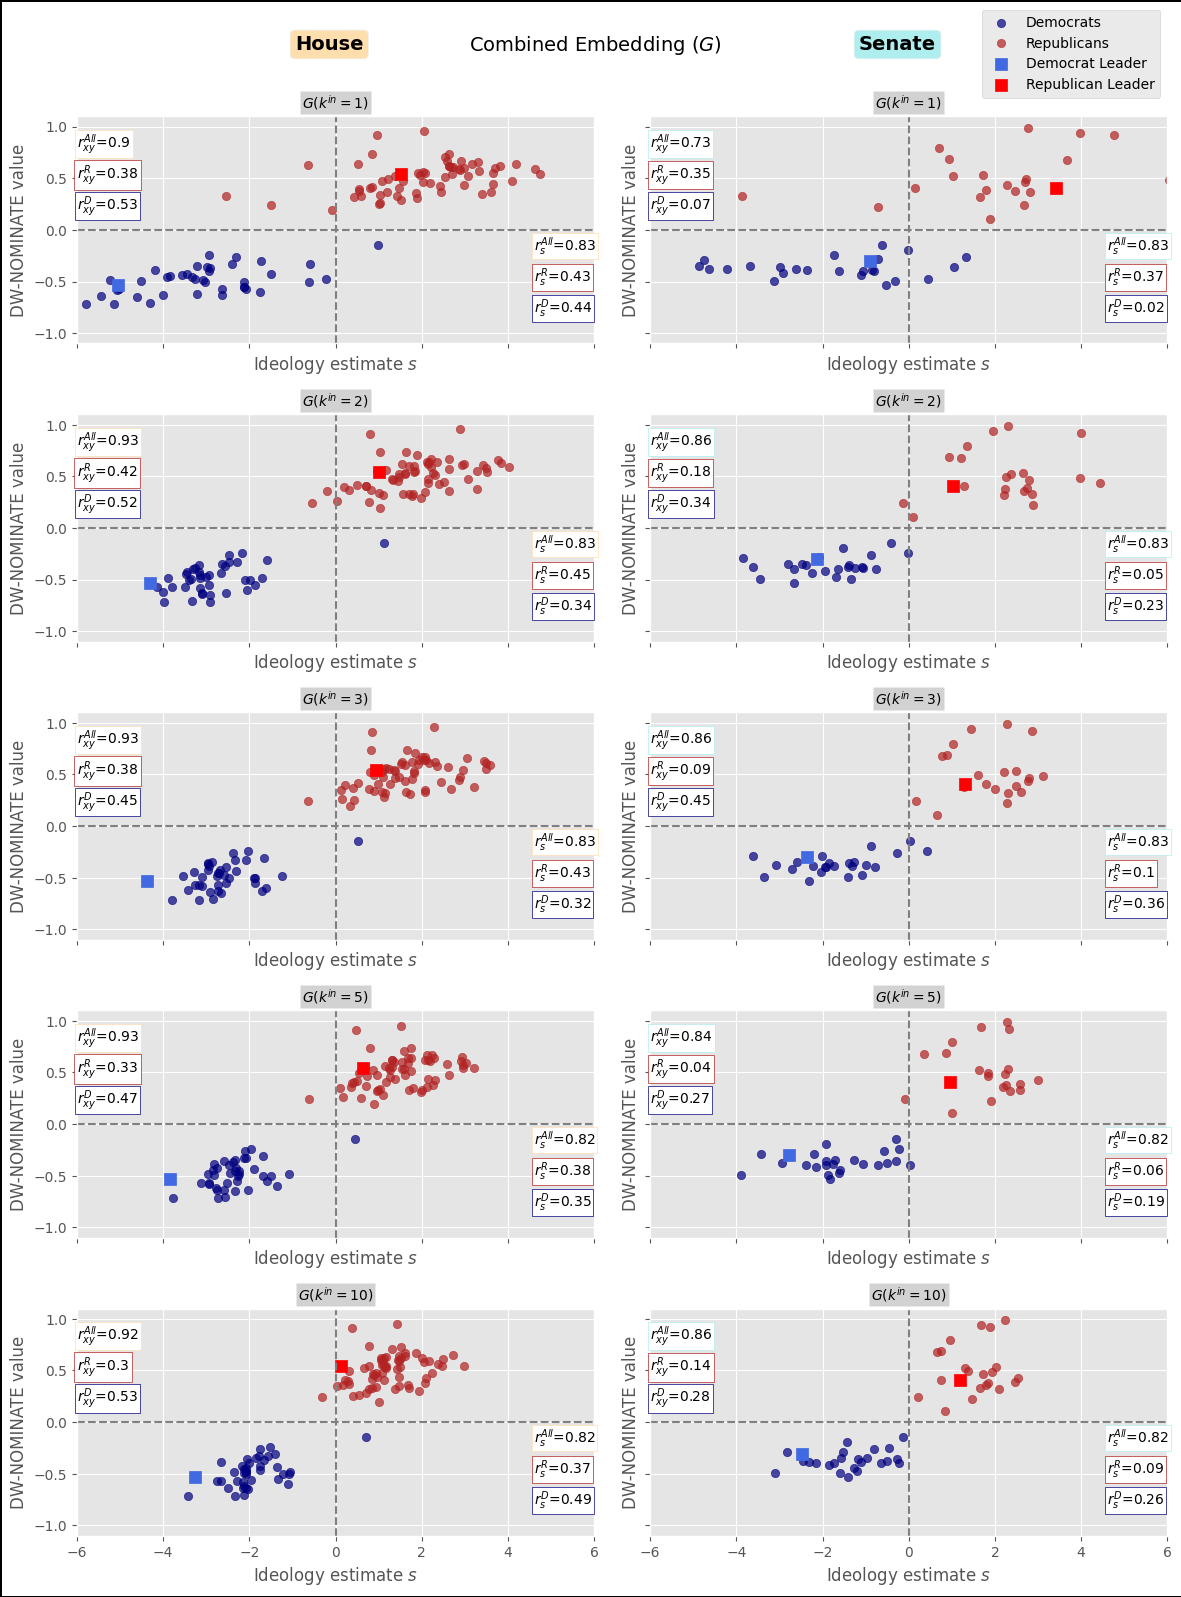

In [498]:
house,senate = plotPC1vsDW(G_house_dict, G_senate_dict, figsize=(12,16), save=True, network_approach='combined', title='Combined Embedding ($G$)')

In [ ]:

with plt.style.context("ggplot"):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i,j in enumerate([1,2,3,5,10]):
        h_list_senate, c_list_senate, kin_senate = computeHomogeneityCompleteness(senate, all_congress_members, kin=j)
        h_list_house, c_list_house, kin_house = computeHomogeneityCompleteness(house, all_congress_members, kin=j)

        axs[0].scatter([i-0.06]*len(h_list_house), h_list_house, color='purple', alpha=0.5, label='Homogeneity')
        axs[0].scatter([i+0.06]*len(c_list_house), c_list_house, color='darkgreen', alpha=0.5, label='Completeness')

        axs[1].scatter([i-0.06]*len(h_list_senate), h_list_senate, color='purple', alpha=0.5, label='Homogeneity')
        axs[1].scatter([i+0.06]*len(c_list_senate), c_list_senate, color='darkgreen', alpha=0.5, label='Completeness')

    axs[0].set_title('House')
    axs[1].set_title('Senate')
    axs[1].legend(['Homogeneity', 'Completeness'],bbox_to_anchor=(1,1.15))

    for ax in axs:
        ax.set_xlabel(r'$k^{in}$ threshold')
        ax.set_ylabel('Score')
        ax.set_ylim([-0.05,1.05])
        ax.set_xticks([0,1,2,3,4])
        ax.set_xticklabels([1,2,3,5,10])

    plt.show()


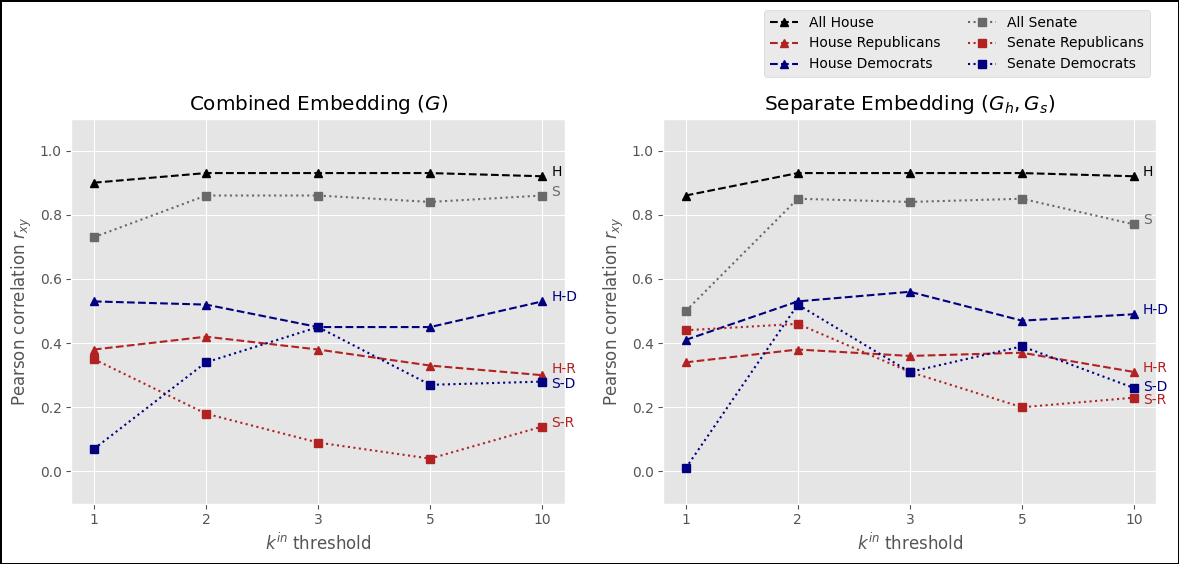

In [476]:
save=True
with plt.style.context("ggplot"):

    fig,axs = plt.subplots(1,2, figsize=(14,5))

    x = range(5)


    # Combined embedding correlations
    combined_house_all = [0.9,0.93,0.93,0.93,0.92]
    combined_senate_all = [0.73,0.86,0.86,0.84,0.86]
    combined_house_republicans = [0.38,0.42,0.38,0.33,0.3]
    combined_house_democrats = [0.53,0.52,0.45,0.45,0.53]
    combined_senate_republicans = [0.35,0.18,0.09,0.04,0.14]
    combined_senate_democrats = [0.07,0.34,0.45,0.27,0.28]

    # Separate embedding correlations
    separate_house_all = [0.86, 0.93, 0.93, 0.93, 0.92]
    separate_senate_all = [0.5,0.85,0.84,0.85,0.77]
    separate_house_republicans = [0.34,0.38,0.36,0.37,0.31]
    separate_house_democrats = [0.41,0.53,0.56,0.47,0.49]
    separate_senate_republicans = [0.44,0.46,0.31,0.2,0.23]
    separate_senate_democrats = [0.01,0.52,0.31,0.39,0.26]


    # Combined plot
    axs[0].plot(x,combined_house_all, label='All House', marker='^', linestyle='dashed', color='black')
    axs[0].annotate('H', xy=(x[-1], combined_house_all[-1]), xytext=(1.02*x[-1], combined_house_all[-1]), color='black')
    axs[0].plot(x,combined_senate_all, label='All Senate',marker='s', linestyle='dotted', color='dimgrey')
    axs[0].annotate('S', xy=(x[-1], combined_senate_all[-1]), xytext=(1.02*x[-1], combined_senate_all[-1]), color='dimgrey')

    axs[0].plot(x,combined_house_republicans,label='House Republicans' ,marker='^', color='firebrick',  linestyle='dashed')
    axs[0].annotate('H-R', xy=(x[-1], combined_house_republicans[-1]), xytext=(1.02*x[-1], combined_house_republicans[-1]*1.02), color='firebrick')
    axs[0].plot(x,combined_house_democrats, label='House Democrats',marker='^', color='navy', linestyle='dashed')
    axs[0].annotate('H-D', xy=(x[-1], combined_house_democrats[-1]), xytext=(1.02*x[-1], combined_house_democrats[-1]), color='navy')
    

    axs[0].plot(x,combined_senate_republicans, label='Senate Republicans',marker='s', color='firebrick',  linestyle='dotted')
    axs[0].annotate('S-R', xy=(x[-1], combined_senate_republicans[-1]), xytext=(1.02*x[-1], combined_senate_republicans[-1]), color='firebrick')
    axs[0].plot(x,combined_senate_democrats, label='Senate Democrats',marker='s', color='navy',  linestyle='dotted')
    axs[0].annotate('S-D', xy=(x[-1], combined_senate_democrats[-1]), xytext=(1.02*x[-1], combined_senate_democrats[-1]*0.93), color='navy')
    axs[0].set_title('Combined Embedding ($G$)')
    axs[0].set_xticks([0,1,2,3,4])
    axs[0].set_xticklabels([1,2,3,5,10])
    axs[0].set_xlabel(r'$k^{in}$ threshold')
    axs[0].set_ylabel(r'Pearson correlation $r_{xy}$')
    axs[0].set_ylim([-0.1,1.1])
    #axs[0].legend()

    # Separate plot
    axs[1].plot(x,separate_house_all, label='All House', marker='^', linestyle='dashed', color='black')
    axs[1].annotate('H', xy=(x[-1], separate_house_all[-1]), xytext=(1.02*x[-1], separate_house_all[-1]), color='black')
    axs[1].plot(x,separate_senate_all, label='All Senate',marker='s', linestyle='dotted', color='dimgrey')
    axs[1].annotate('S', xy=(x[-1], separate_senate_all[-1]), xytext=(1.02*x[-1], separate_senate_all[-1]), color='dimgrey')

    axs[1].plot(x,separate_house_republicans,label='House Republicans' ,marker='^', color='firebrick',  linestyle='dashed')
    axs[1].annotate('H-R', xy=(x[-1], separate_house_republicans[-1]), xytext=(1.02*x[-1], separate_house_republicans[-1]), color='firebrick')
    axs[1].plot(x,separate_house_democrats, label='House Democrats',marker='^', color='navy',  linestyle='dashed')
    axs[1].annotate('H-D', xy=(x[-1], separate_house_democrats[-1]), xytext=(1.02*x[-1], separate_house_democrats[-1]), color='navy')

    axs[1].plot(x,separate_senate_republicans, label='Senate Republicans',marker='s', color='firebrick',  linestyle='dotted')
    axs[1].annotate('S-R', xy=(x[-1], separate_senate_republicans[-1]), xytext=(1.02*x[-1], separate_senate_republicans[-1]*0.91), color='firebrick')
    axs[1].plot(x,separate_senate_democrats, label='Senate Democrats',marker='s', color='navy',  linestyle='dotted')
    axs[1].annotate('S-D', xy=(x[-1], separate_senate_democrats[-1]), xytext=(1.02*x[-1], separate_senate_democrats[-1]*0.97), color='navy')
    axs[1].set_title('Separate Embedding ($G_h, G_s$)')
    axs[1].set_xticks([0,1,2,3,4])
    axs[1].set_xticklabels([1,2,3,5,10])
    axs[1].set_xlabel(r'$k^{in}$ threshold')
    axs[1].set_ylabel(r'Pearson correlation $r_{xy}$')
    axs[1].set_ylim([-0.1,1.1])

    #axs[1].legend(loc='upper right', bbox_to_anchor=(1,1.45), ncol=3)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,3,1,4,5]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right', bbox_to_anchor=(1,1.3), ncol=2)

    fig.patch.set_edgecolor('black')  # Set border color
    fig.patch.set_linewidth(1) 

    if save:
        current_ts = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig('results/figures/correlations_{}'.format(current_ts), bbox_inches='tight', dpi=400, format='pdf')

    plt.show()


**Separate embedding**

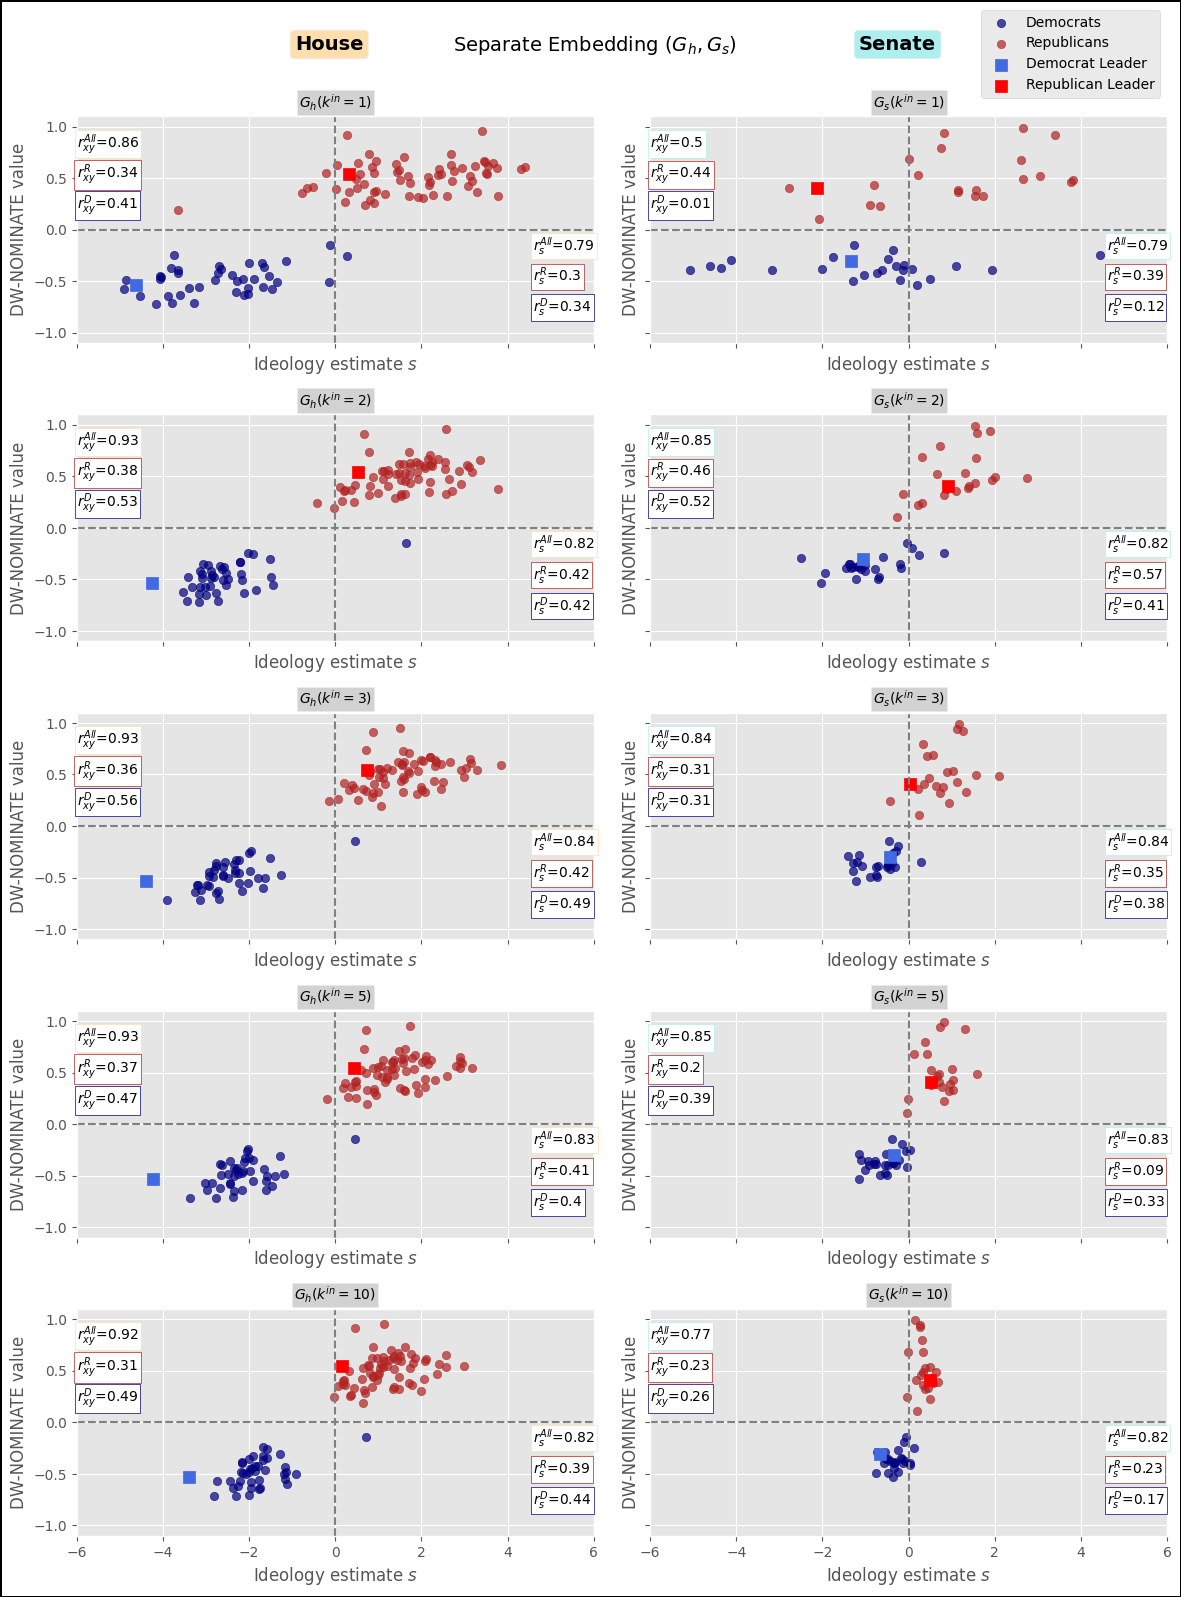

In [494]:
house_return,senate_return = plotPC1vsDW(G_h_house_dict, G_s_senate_dict, figsize=(12,16), network_approach='separate',save=True,title='Separate Embedding ($G_h, G_s$)')

In [481]:
house_return

,congressperson,first_pc,party,dw.nom.1
0,jahimes,1.913261,D,-0.258
1,jacksonleetx18,2.821048,D,-0.475
2,askgeorge,1.851938,D,-0.602
3,repkenmarchant,-3.106745,R,0.593
4,repperlmutter,2.209052,D,-0.328
...,...,...,...,...
104,petesessions,-2.052764,R,0.600
105,alangrayson,2.575869,D,-0.384
106,jim_jordan,-2.391638,R,0.670
107,peteolson,-2.948535,R,NaN


In [480]:
house_return.to_csv('house_ideological_scores.csv')
senate_return.to_csv('senate_ideological_scores.csv')

#### 2.2 Plot Principal Components

## **3. Compare first principcal component to DW-Nominate score**

In [17]:
first_pca = computePCA(embeddings_dct, 1)
first_pca_df = pd.DataFrame.from_dict(first_pca, orient='index').reset_index().rename(columns = {'index' : 'congressperson', 0 : 'first_pc'})

In [18]:
democrats_house = democrats.merge(first_pca_df, on='congressperson', how='left')
republicans_house = republicans.merge(first_pca_df, on='congressperson', how='left')

democrats_house = democrats_house[democrats_house['chamber'] == 'House'].dropna(subset=['first_pc'])
republicans_house = republicans_house[republicans_house['chamber'] == 'House'].dropna(subset=['first_pc'])

In [19]:
with plt.style.context("ggplot"):



    plt.figure(figsize=(11,7))

    x1 = democrats_house.dropna(subset=['dw.nom.1'])['dw.nom.1']
    y1 = democrats_house.dropna(subset=['dw.nom.1'])['first_pc']
    nancy = democrats_house[democrats_house['congressperson'] == 'speakerpelosi']
    nancy_x = nancy['dw.nom.1']
    nancy_y = nancy['first_pc']
    democrat_corr = np.round(stats.pearsonr(x1,y1).statistic,2)

    x2 = republicans_house.dropna(subset=['dw.nom.1'])['dw.nom.1']
    y2 = republicans_house.dropna(subset=['dw.nom.1'])['first_pc']
    republican_corr = np.round(stats.pearsonr(x2,y2).statistic,2)

    all_x = pd.concat([x1,x2])
    all_y = pd.concat([y1, y2])
    all_corr = np.round(stats.pearsonr(all_x, all_y).statistic,2)

    
    plt.scatter(x1,y1, label='Democrats', color='navy', marker=r'$D$')
    plt.scatter(x2, y2, label='Republicans', color='red', marker=r'$R$')
    plt.scatter(nancy_x,nancy_y, color='green', marker='o', s=80, label='Nancy Pelosi')
    plt.annotate(r'$\rho_D$={}'.format(democrat_corr), (-0.6,3.3), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))
    plt.annotate(r'$\rho_R$={}'.format(republican_corr), (1,1), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))
    plt.annotate(r'$\rho_{{All}}$={}'.format(all_corr), (0,-1.5), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))

    plt.axvline(x=0, color='grey', linestyle='dashed')
    plt.axhline(y=0, color='grey', linestyle='dashed')

    plt.xlabel('DW-Nominate score')
    plt.ylabel('PC1 (Opinion Score)')
    plt.title('PC1 of embedding vs. Ground-truth DW-Nominate (Actual)', size=10)
    plt.legend()
    plt.show()

ValueError: x and y must have length at least 2.

## **4. Compare rankings by method**

In [30]:
all_house = pd.concat([democrats_house, republicans_house])
all_house['DW-Nominate_rank'] = all_house['dw.nom.1'].rank(ascending=True)
all_house['first_pc_rank'] = all_house['first_pc'].rank(ascending=True)

democrats_house_ranked = all_house[all_house['party'] == 'D']
republicans_house_ranked = all_house[all_house['party'] == 'R']

In [31]:
with plt.style.context("ggplot"):

    plt.figure(figsize=(11,7))
    
    x1 = democrats_house_ranked['DW-Nominate_rank']
    y1 = democrats_house_ranked['first_pc_rank']
    democrat_rank_corr = np.round(stats.pearsonr(x1,y1).statistic,2)

    x2 = republicans_house_ranked['DW-Nominate_rank']
    y2 = republicans_house_ranked['first_pc_rank']
    republican_rank_corr = np.round(stats.pearsonr(x1,y1).statistic,2)

    all_rank_x = pd.concat([x1,x2])
    all_rank_y = pd.concat([y1, y2])
    all_rank_corr = np.round(stats.pearsonr(all_rank_x, all_rank_y).statistic,2)
    
    plt.scatter(x1,y1, label='democrats', color='navy', marker=r'$D$')
    plt.scatter(x2, y2, label='republicans', color='red', marker=r'$R$')

    plt.annotate(r'$\rho_D$={}'.format(democrat_rank_corr), (45,100), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))
    plt.annotate(r'$\rho_R$={}'.format(republican_rank_corr), (90,65), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))
    plt.annotate(r'$\rho_{{All}}$={}'.format(all_rank_corr), (30,40), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))


    plt.xlabel('DW-Nominate ranking')
    plt.ylabel('PC1 ranking')
    plt.title('PC1 of embedding vs. Ground-truth DW-Nominate (ranking)', size=10)
    plt.legend()
    plt.show()

ValueError: array must not contain infs or NaNs